# Fine-Tuning GPT-2 to increase coherence in extractive summaries





In [205]:
#pytorch part is based on this https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/
#https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=NKGBoVwuhM4H

# Setup

In [2]:
import os
import time
import datetime
#from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
#% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

from tqdm.notebook import tqdm

from nltk.tokenize import word_tokenize, sent_tokenize

import matplotlib

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import statistics

import numpy as np
import math

2023-05-14 21:34:26.193260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /home/i.akhmetov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import pickle
def save_obj(obj, name):
    pickle.dump(obj,open(name + '.pkl', 'wb'), protocol=4)
    
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [2]:
!nvidia-smi

Sat Apr 15 23:43:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:09:00.0 Off |                    0 |
| N/A   64C    P0    87W / 300W |  31475MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:0A:00.0 Off |                    0 |
| N/A   

# Data

## Load Data

In [1]:
# data is available at https://drive.google.com/file/d/1PyxyXExQo--YKVKaUYSIdIZ-qBzmNWa0/view?usp=sharing

In [10]:
ds = pd.read_csv('abstracts.csv', '\t')
ds.head()

/tmp/ipykernel_218325/3328218577.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  ds = pd.read_csv('abstracts.csv', '\t')


,abstract_text,best_summary_gen_greedinit
0,large numbers of supernovae ( sne ) have been ...,the method presented here can become significa...
1,we investigate the emergence of magnetic flux ...,an important result is that 23% of the loops a...
2,the estimation of the number of passengers wit...,the ad - hoc estimation is plotted in green. t...
3,the classical structure - function ( sf ) meth...,this procedure is designated as detrending ana...
4,"given a real number @xmath0 , we study the ass...",the previous theorem can be proved also just u...


## Explore data

In [11]:
# length in charcters
ds['abs_len'] = [len(t) for t in ds.abstract_text]
ds['best_sum_len'] = [len(t) for t in ds.best_summary_gen_greedinit]

In [12]:
ds.describe()

,abs_len,best_sum_len
count,16772.000000,16772.000000
mean,1833.826497,1982.895123
std,467.974779,504.264747
min,440.000000,678.000000
25%,1528.000000,1637.000000
50%,1762.000000,1907.000000
75%,2069.000000,2248.000000
max,3978.000000,3999.000000


In [13]:
# length in word tokens
ds['abs_len_wt'] = [len(word_tokenize(t)) for t in tqdm(ds.abstract_text)]
ds['best_sum_len_wt'] = [len(word_tokenize(t)) for t in  tqdm(ds.best_summary_gen_greedinit)]
ds['comb_len_wt'] = ds.abs_len_wt.values + ds.best_sum_len_wt.values

  0%|          | 0/16772 [00:00<?, ?it/s]

  0%|          | 0/16772 [00:00<?, ?it/s]

In [14]:
ds['abs_num_sent'] = [len(sent_tokenize(t)) for t in tqdm(ds.abstract_text)]
ds['best_sum_num_sent'] = [len(sent_tokenize(t)) for t in tqdm(ds.best_summary_gen_greedinit)]

  0%|          | 0/16772 [00:00<?, ?it/s]

  0%|          | 0/16772 [00:00<?, ?it/s]

<Axes: >

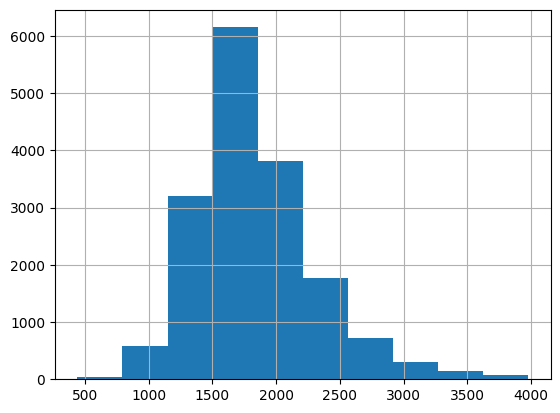

In [25]:
ds.abs_len.hist()

<Axes: >

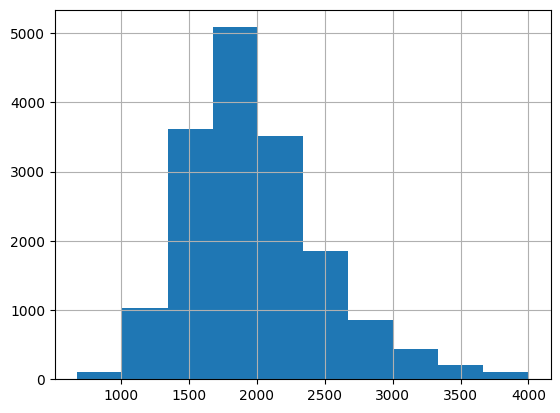

In [26]:
ds.best_sum_len.hist()

<Axes: >

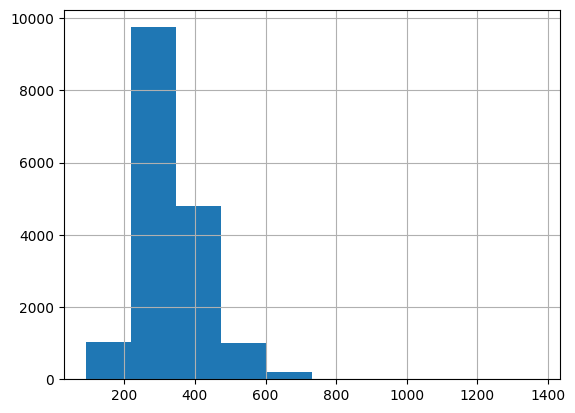

In [27]:
ds.abs_len_wt.hist()

<Axes: >

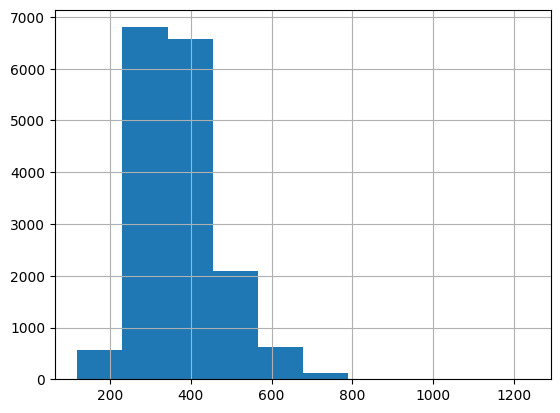

In [28]:
ds.best_sum_len_wt.hist()

<Axes: >

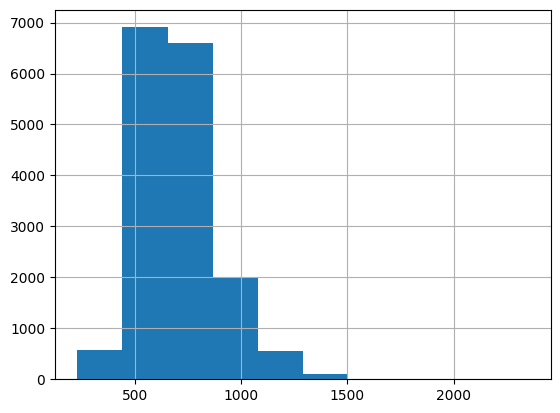

In [29]:
ds.comb_len_wt.hist()

<Axes: >

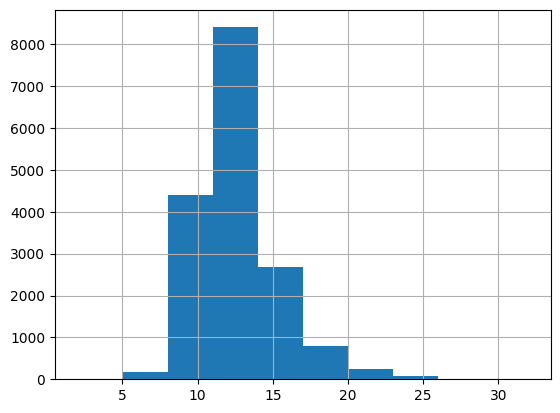

In [30]:
ds.abs_num_sent.hist()

<Axes: >

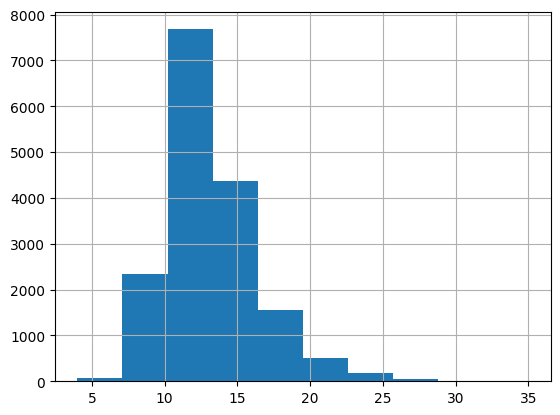

In [31]:
ds.best_sum_num_sent.hist()

In [16]:
ds.describe()

,abs_len,best_sum_len,abs_len_wt,best_sum_len_wt,comb_len_wt,abs_num_sent,best_sum_num_sent
count,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000
mean,1833.826497,1982.895123,333.276115,370.380754,703.656869,12.121929,13.347067
std,467.974779,504.264747,89.187307,96.047723,179.414725,2.647065,3.064613
min,440.000000,678.000000,92.000000,119.000000,230.000000,2.000000,4.000000
25%,1528.000000,1637.000000,274.000000,304.000000,582.000000,10.000000,11.000000
50%,1762.000000,1907.000000,318.000000,355.000000,674.000000,12.000000,13.000000
75%,2069.000000,2248.000000,377.000000,421.000000,795.000000,13.000000,15.000000
max,3978.000000,3999.000000,1369.000000,1236.000000,2351.000000,32.000000,35.000000


## Cleanse data

In [21]:
ds[(ds.comb_len_wt<=1000)&(ds.abs_num_sent>=5)].describe()

,abs_len,best_sum_len,abs_len_wt,best_sum_len_wt,comb_len_wt,abs_num_sent
count,15590.000000,15590.000000,15590.000000,15590.000000,15590.000000,15590.000000
mean,1754.392046,1897.688775,317.639513,353.748428,671.387941,12.214625
std,364.712604,399.087170,68.037851,74.828562,136.578074,2.546178
min,440.000000,678.000000,92.000000,119.000000,230.000000,5.000000
25%,1508.250000,1615.000000,271.000000,300.000000,575.000000,11.000000
50%,1729.000000,1870.000000,312.000000,348.000000,661.000000,12.000000
75%,1987.000000,2164.000000,361.000000,404.000000,763.000000,13.000000
max,3439.000000,3398.000000,648.000000,621.000000,1000.000000,36.000000


In [22]:
ds = ds[(ds.comb_len_wt<=1000)&(ds.abs_num_sent>=5)]

## Data preprocessing

In [23]:
def remove_spec_char(text):
    valid_chars = 'abcdefghijklmnopqrstuvwxyz .'
    return ''.join([c for c in text if c in valid_chars])
    
remove_spec_char('dd324234*(^&*%&%*')

'dd'

In [24]:
ds.abstract_text = [remove_spec_char(t) for t in ds.abstract_text.values]
ds.best_summary_gen_greedinit = [remove_spec_char(t) for t in ds.best_summary_gen_greedinit.values]
ds.head()

/tmp/ipykernel_36524/2838607108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.abstract_text = [remove_spec_char(t) for t in ds.abstract_text.values]
/tmp/ipykernel_36524/2838607108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.best_summary_gen_greedinit = [remove_spec_char(t) for t in ds.best_summary_gen_greedinit.values]


,abstract_text,best_summary_gen_greedinit,abs_len,best_sum_len,abs_len_wt,best_sum_len_wt,comb_len_wt,abs_num_sent
0,large numbers of supernovae sne have been di...,the method presented here can become significa...,1658,1780,315,340,655,14
1,we investigate the emergence of magnetic flux ...,an important result is that of the loops are ...,1424,1541,252,274,526,12
2,the estimation of the number of passengers wit...,the ad hoc estimation is plotted in green. th...,1424,1364,254,241,495,11
3,the classical structure function sf method ...,this procedure is designated as detrending ana...,1950,1954,342,351,693,17
4,given a real number xmath we study the associ...,the previous theorem can be proved also just u...,1202,1340,232,272,504,11


### Measure cohesion

In [195]:
model_emb = SentenceTransformer('bert-base-nli-mean-tokens')
def cohesion_measure(text):
    # based on https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1
    try:
        #tokenize text by sentences
        sentences = sent_tokenize(text)


        sentence_embeddings = model_emb.encode(sentences)
        #seq_sims = statistics.median([cosine_similarity(sentence_embeddings[i].reshape(1, -1), sentence_embeddings[i+1].reshape(1, -1)) for i in range(len(sentence_embeddings)-1)])
        seq_sims = np.array([cosine_similarity(sentence_embeddings[i].reshape(1, -1), sentence_embeddings[i+1].reshape(1, -1)) for i in range(len(sentence_embeddings)-1)])
        if (any(seq_sims) == False)or(seq_sims.sum() == np.nan)or(seq_sims.sum() == 0)or(seq_sims.std() == 0):
            return 0
        coh = 1/(seq_sims.std()/seq_sims.mean())#seq_sims[0][0]
        return coh
    except:
        return 0

# extractive summary
text = ds.abstract_text.values[0]
#abstractive summary
text2 = ds.best_summary_gen_greedinit.values[0]
print(cohesion_measure(text))
print(cohesion_measure(text2))

4.0397745441376465
3.7750922722198683


In [26]:
# Cohesions per extractive and abstractive summaries
ext_cohes = [cohesion_measure(text) for text in tqdm(ds.best_summary_gen_greedinit.values)]
abs_cohes = [cohesion_measure(text) for text in tqdm(ds.abstract_text.values)]
print('Extractive cohesions (mean)', sum(ext_cohes)/len(ext_cohes))
print('Abstractive cohesions (mean)', sum(abs_cohes)/len(abs_cohes))

  0%|          | 0/15590 [00:00<?, ?it/s]

  0%|          | 0/15590 [00:00<?, ?it/s]

Extractive cohesions (mean) 3.6984899027449916
Abstractive cohesions (mean) 4.524933054215752


In [28]:
print('Extractive cohesions (median)', statistics.median(ext_cohes))
print('Abstractive cohesions (median)', statistics.median(abs_cohes))

Extractive cohesions (median) 3.405440522638286
Abstractive cohesions (median) 4.161314530389809


In [29]:
#Kolmogorov-Smirnov test based on https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
from scipy import stats
stats.kstest(ext_cohes, abs_cohes)

KstestResult(statistic=0.24862091084028226, pvalue=0.0, statistic_location=3.81436553824104, statistic_sign=1)

The p-value is less than 0.05, so we reject the null hypothesis and assume the two samples are from different distributions

In [30]:
# Z-test based on http://homework.uoregon.edu/pub/class/es202/ztest.html#:~:text=If%20the%20Z%2Dstatistic%20is,two%20samples%20are%20significantly%20different
X1 = sum(ext_cohes)/len(ext_cohes)
X2 = sum(abs_cohes)/len(abs_cohes)
s1 = np.std(ext_cohes)/math.sqrt(len(ext_cohes))
s2 = np.std(abs_cohes)/math.sqrt(len(abs_cohes))
Z = abs(X1-X2)/math.sqrt(s1**2+s2**2)
Z

47.02503945410842

In general, in more qualitative terms:

- If the Z-statistic is less than 2, the two samples are the same.
- If the Z-statistic is between 2.0 and 2.5, the two samples are marginally different
- If the Z-statistic is between 2.5 and 3.0, the two samples are significantly different
- If the Z-statistic is more then 3.0, the two samples are highly signficantly different

The Z value is more than 3.0, so the two samples are highly significantly different

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [31]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


## Define the Extractive-Abstractive pairs

In [56]:
#set aside test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds.best_summary_gen_greedinit.values, ds.abstract_text.values, test_size=0.1, random_state=2023)

In [57]:
ea_pairs = ['E: ' + e + ' A: ' + a for e,a in zip(tqdm(X_train), y_train)]
ea_pairs_test = ['E: ' + e + ' A: ' + a for e,a in zip(tqdm(X_test), y_test)]

  0%|          | 0/14031 [00:00<?, ?it/s]

  0%|          | 0/1559 [00:00<?, ?it/s]

In [58]:
ea_pairs[0]

'E: we focus upon the non  degenerate case of high temperatures and low doping  xmath. both xmath and xmath asymptote toward perfectly finite values at non  zero xmath and xmath  even in the absence of disorder  in accord with the results of ref. . it has been therefore claimed that the electronic component xmath of the thermal conductivity of clean  undoped graphene is infinitexcite being limited only by the amount disorder in a dirty sample.  real electron  phonon collisions may modify  i  the imbalance relaxation rate due to electron  hole pair to phonon conversion processes   ii  the inhomogeneous electronic temperature profile  due to energy exchange with the phonon bath  and  iii  the thermoelectric power through phonon drag. contact resistance can be controlled in principle through the incorporation of a highly insulating spacer layer of varying thickness between the graphene and the contact metal.      in the opposite limit where the sample length xmath exceeds the imbalance re

In [59]:
ea_pairs_test[0]

'E: in addition  a curve can also be defined as a connected  one  dimensional  compact point set. by effectivizing all these approaches to curves open   or  namely  the sets of points covered by the four classes of computable curves are different. if we look only at curves of computable lengths  then the four effectivizations mentioned above are indeed equivalent. namely  the sets of points covered by the four classes of computable curves are different. let xmath be the part of xmath in the box xmath. this means that the definition of computable curves is robust  at least  for curves of computable lengths. on the other hand  gu  lutz and mayordomo constructed in xcite a computable curve of non  computable length such that none of its computable parametrizations can be injective  open   or  i.e.  if the class of computable curves of computable lengths is point  separable from the class of computable curves of finite lengths. a positive answer will be given in this paper. we will see tha

In [61]:
#get max word length
max_text_len = max([len(word_tokenize(w)) for w in tqdm(ea_pairs)]+[len(word_tokenize(w)) for w in tqdm(ea_pairs_test)])
max_text_len

  0%|          | 0/14031 [00:00<?, ?it/s]

  0%|          | 0/1559 [00:00<?, ?it/s]

943

# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [62]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [63]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [64]:
dataset = GPT2Dataset(ea_pairs, tokenizer, max_length=max_text_len)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

12,627 training samples
1,404 validation samples


In [65]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [66]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [67]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [68]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [69]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [70]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [71]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=50257,#random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = max_text_len,
                                    top_p=0.95, 
                                    num_return_sequences=1,
                                    pad_token_id=tokenizer.eos_token_id
                                )
            # for i, sample_output in enumerate(sample_outputs):
            #       print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch   100  of  6,314. Loss: 2.913390636444092.   Elapsed: 0:00:15.
  Batch   200  of  6,314. Loss: 2.8453927040100098.   Elapsed: 0:00:33.
  Batch   300  of  6,314. Loss: 2.7716071605682373.   Elapsed: 0:00:55.
  Batch   400  of  6,314. Loss: 1.5646151304244995.   Elapsed: 0:01:10.
  Batch   500  of  6,314. Loss: 3.1968233585357666.   Elapsed: 0:01:31.
  Batch   600  of  6,314. Loss: 2.2604453563690186.   Elapsed: 0:01:53.
  Batch   700  of  6,314. Loss: 2.8680219650268555.   Elapsed: 0:02:16.
  Batch   800  of  6,314. Loss: 2.3751161098480225.   Elapsed: 0:02:39.
  Batch   900  of  6,314. Loss: 2.574906587600708.   Elapsed: 0:03:01.
  Batch 1,000  of  6,314. Loss: 2.4557178020477295.   Elapsed: 0:03:23.
  Batch 1,100  of  6,314. Loss: 1.9270150661468506.   Elapsed: 0:03:45.
  Batch 1,200  of  6,314. Loss: 2.5566492080688477.   Elapsed: 0:04:07.
  Batch 1,300  of  6,314. Loss: 2.4371495246887207.   Elapsed: 0:04:28.
  Batch 1,400  of  6,31

Let's view the summary of the training process.

In [73]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.46,2.22,0:22:33,0:00:34
2,2.18,2.14,0:22:15,0:00:34
3,2.00,2.10,0:21:57,0:00:34
4,1.84,2.08,0:22:15,0:00:34
5,1.69,2.10,0:22:10,0:00:34


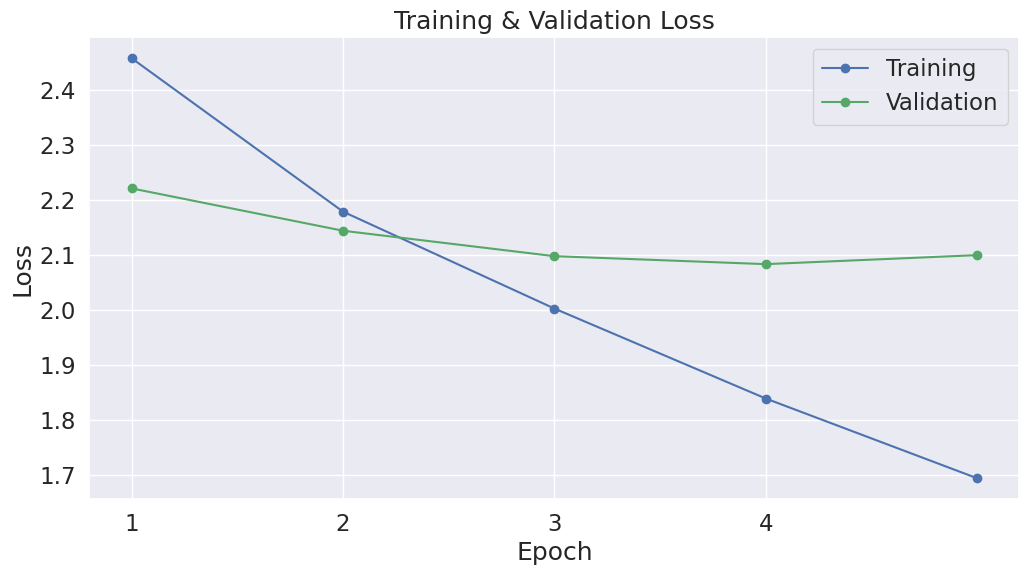

In [74]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [75]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [77]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [78]:
!ls -l --block-size=K ./model_save/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 499888K
-rw-r--r-- 1 i.akhmetov i.akhmetov      1K Apr 16 03:48 added_tokens.json
-rw-r--r-- 1 i.akhmetov i.akhmetov      1K Apr 16 03:48 config.json
-rw-r--r-- 1 i.akhmetov i.akhmetov      1K Apr 16 03:48 generation_config.json
-rw-r--r-- 1 i.akhmetov i.akhmetov    446K Apr 16 03:48 merges.txt
-rw-r--r-- 1 i.akhmetov i.akhmetov 498442K Apr 16 03:48 pytorch_model.bin
-rw-r--r-- 1 i.akhmetov i.akhmetov      1K Apr 16 03:48 special_tokens_map.json
-rw-r--r-- 1 i.akhmetov i.akhmetov      1K Apr 16 03:48 tokenizer_config.json
-rw-r--r-- 1 i.akhmetov i.akhmetov    976K Apr 16 03:48 vocab.json


In [79]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
-rw-r--r-- 1 i.akhmetov i.akhmetov 487M Apr 16 03:48 ./model_save/pytorch_model.bin


In [96]:
# Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

# Generate Text

In [80]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: E:  in   the local density contrast between the dust and gas can be estimated as  xmath at xmath  xmath at xmath  and xmath at xmath. it is believed that dust extinction occurs in the outer parts of galaxies  where the total dust mass is larger than the local density  and therefore  the dust  gas collision rate is lower than the escape rate.    in the present paper  we present the collision rate derived from the gas and dust  cloud collision history based on the local density fluctuation relation  lddt  for three different dust  cloud merger model parameters     the fraction of gas affected by dust  cloud collision and    the fraction of dust  cloud collisional scatter. the xmath dependence of the dust  cloud collision rate  for the lddt  is shown as in figure   and as a function of dust  cloud mass  luminosity  luminosity   gas fraction  xmath  and dust  cloud velocity. xcite presented the dust  cloud collision history based on the local density f

These aren't bad at all!


# Generate Abstractive summaries from Extractive ones

In [84]:
model.eval()

def generate_response(question):
    # Encode the question using the tokenizer
    #input_ids = tokenizer.encode(question + " <|question|>", add_special_tokens=False, return_tensors='pt').to(device)
    input_ids = tokenizer.encode(question, add_special_tokens=True, return_tensors='pt').to(device)

    # Generate the answer using the model
    sample_output = model.generate(input_ids, do_sample=True, max_length=max_text_len, top_k=20, top_p=1.0, pad_token_id=tokenizer.eos_token_id)

    # Decode the generated answer using the tokenizer
    #answer = tokenizer.decode(sample_output[0], skip_special_tokens=True)
    answer = ' '.join([tokenizer.decode(so, skip_special_tokens=True) for so in sample_output])

    # Split the generated answer into individual sentences
    # sentences = sent_tokenize(answer) #answer.split('. ')

    # Look for the sentence that contains the answer to the question
    # for sentence in sentences:
    #     if question in sentence:
    #         return sentence

    # If no sentence contains the answer, return the full generated answer
    return answer

## Example usage

In [85]:
question = '<|startoftext|> E:  k - corrections for sne of all types , and at all ages , are currently unknown. instead , we have compiled a large spectral database of nearby , well - observed sne. as we move even farther up the redshift scale the use of infrared ( ir ) filters is required. between @xmath73 and @xmath74 , classification would require a combination of optical and ir photometry. is required. , we can extend our analysis to higher redshifts. one can see that the unique colors of young ( @xmath40  d ) and very old ( @xmath31  d ) sne  ia can not be masked even by significant reddening in their host. finally , we have demonstrated the application of our method to a recently discovered sn from the sdss , and we have shown how this technique may become a valuable tool for the analysis of the large sn samples expected to emerge from this and other programs that are already active or will begin soon. A:'
response = generate_response(question)
#print(f"{question}\n {response}")
print(response[:response.index('A:')])
print()
print(response[response.index('A:'):])

 E:  k - corrections for sne of all types, and at all ages, are currently unknown. instead, we have compiled a large spectral database of nearby, well - observed sne. as we move even farther up the redshift scale the use of infrared ( ir ) filters is required. between @xmath73 and @xmath74, classification would require a combination of optical and ir photometry. is required., we can extend our analysis to higher redshifts. one can see that the unique colors of young ( @xmath40  d ) and very old ( @xmath31  d ) sne  ia can not be masked even by significant reddening in their host. finally, we have demonstrated the application of our method to a recently discovered sn from the sdss, and we have shown how this technique may become a valuable tool for the analysis of the large sn samples expected to emerge from this and other programs that are already active or will begin soon. 

A: we are applying the new infraredinformation technology  ibl     to a large sample of wellknown well  observe

large numbers of supernovae ( sne ) have been discovered in recent years , and many more will be found in the near future. once discovered , further study of a sn and its possible use as an astronomical tool ( e.g. , as a distance estimator ) require knowledge of the sn type. current classification methods rely almost solely on the analysis of sn spectra to determine their type. however , spectroscopy may not be possible or practical when sne are faint , numerous , or discovered in archival studies. we present a classification method for sne based on the comparison of their observed colors with synthetic ones , calculated from a large database of multi - epoch optical spectra of nearby events. we discuss the capabilities and limitations of this method. for example , type ia sne at redshifts @xmath0 can be distinguished from most other sn types during the first few weeks of their evolution , based on @xmath1 vs. @xmath2 colors. type ii - p sne have distinct ( very red ) colors at late ( @xmath3  d ) stages. broadband photometry through standard johnson - cousins @xmath4 filters can be useful to classify sne out to @xmath5. the use of sloan digital sky survey ( sdss ) @xmath6 filters allows the extension of our classification method to even higher redshifts ( @xmath7 ) , and the use of infrared bands , to @xmath8. we demonstrate the application of this method to a recently discovered sn from the sdss. finally , we outline the observational data required to further improve the sensitivity of the method , and discuss prospects for its use on future sn samples. community access to the tools developed is provided by a dedicated website.	the method presented here can become significantly more powerful when more observational data become available. once discovered , the study of a particular sn , and its use as a tool for any of the applications above , is almost always based on spectroscopic verification and classification. this demonstrates the well - known variety of late - type spectra of sne  ii ( filippenko 1997 ). in subsequent plots , the temporal coverage of our compilation allows us to draw paths in color space which show the time evolution of each sn type. inspecting the resulting diagrams once discovered , the study of a particular sn , and its use as a tool for any of the applications above , is almost always based on spectroscopic verification and classification. since we want to constrain the type of a sn with an arbitrary ( but known ) redshift , it is not simple to utilize broadband photometry 

# Bulk testing

## Test set

In [86]:
#NUM_TEST = 5000

#test_texts = X_test #texts[:NUM_TEST]

inputs = []
outputs = []
predicts = []

for e, a in zip(tqdm(X_test), y_test):
    input_txt = '<|startoftext|> E:'+ e #t[:response.index('A:')]
    inputs.append(input_txt)
    
    output_txt = 'A: ' + a #t[response.index('A:'):]
    outputs.append(output_txt)
    
    predict = generate_response(input_txt)#[:response.index('A:')]
    predicts.append(predict)
    
    

  0%|          | 0/1559 [00:00<?, ?it/s]

In [132]:
# predicts2 = [predicts[i].index('A: ') for i in tqdm(range(len(predicts)))]
# predicts2[0]

def get_generated(predicted,inpt):
    p_sents = sent_tokenize(predicted)
    i_sents = sent_tokenize(inpt)
    return ' '.join(p_sents[len(i_sents):])
# for p, i in zip(tqdm(predicts), inputs):
    
#     break
#get_generated(predicts[0],inputs[0])
predicts2 = [get_generated(p, i) for p, i in zip(tqdm(predicts), inputs)]
predicts2[0]

  0%|          | 0/1559 [00:00<?, ?it/s]

'xmath        a nontrivial set of classes of curves of computable lengths that can be expressed as nontrivial sets have been defined in xcite. A: a nontrivial set of classes of curves of computable lengths is studied. its existence has been proved for curves of computable lengths in the previous section. for the class of curves of computable lengths xmath  the existence of a class of nontrivial sets of curves with nontrivial set of classes is proved for non  trivial classes of curves of nontrivial sets of computable lengths. this class contains the set of non  trivial curves of computable length of non  computable length that can be injective or  i.e. if the class of curves of computable lengths is point  separable from the class of nontrivial sets of computable length of finite lengths. the class of nontrivial sets of curves is defined as the ones that satisfy certain conditions of the class of curves of computable lengths for which the class of nontrivial sets of curves has not been 

### Cohesion of the predicts

In [160]:
# Measure cohesion of the predicts
predict_cohes = [cohesion_measure(text) for text in tqdm(predicts2)]
input_cohes = [cohesion_measure(text) for text in tqdm(inputs)] #ext_cohes[:NUM_TEST]
output_cohes = [cohesion_measure(text) for text in tqdm(outputs)] #abs_cohes[:NUM_TEST]

  0%|          | 0/1559 [00:00<?, ?it/s]

  0%|          | 0/1559 [00:00<?, ?it/s]

  0%|          | 0/1559 [00:00<?, ?it/s]

In [162]:
zero_filter = [(pc != 0)&(pc != np.nan) for pc in predict_cohes]
print(sum(zero_filter))
predict_cohes = np.array(predict_cohes)[zero_filter]
input_cohes = np.array(input_cohes)[zero_filter]
output_cohes = np.array(output_cohes)[zero_filter]

1558


In [163]:
predict_cohes.sum()

6672.562336624206

In [164]:
X1 = input_cohes.mean()
X2 = predict_cohes.mean()
X3 = output_cohes.mean()

print('Input cohesions (mean)', X1) 
print('Predict cohesions (mean)', X2) 
print('Output cohesions (mean)', X3) 


Input cohesions (mean) 3.713856621059406
Predict cohesions (mean) 4.28277428538139
Output cohesions (mean) 4.4871062420761785


In [165]:
#Kolmogorov-Smirnov test based on https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
#Compare distributions of input and predict cohesions
from scipy import stats
stats.kstest(input_cohes, predict_cohes)

KstestResult(statistic=0.18806161745827984, pvalue=1.7188421145546352e-24, statistic_location=3.358822511328648, statistic_sign=1)

The p-value is less than 0.05, so we reject the null hypothesis and assume the two samples are from different distributions

In [166]:
# Z-test based on http://homework.uoregon.edu/pub/class/es202/ztest.html#:~:text=If%20the%20Z%2Dstatistic%20is,two%20samples%20are%20significantly%20different
# X1 = sum(input_cohes)/len(input_cohes)
# X2 = sum(predict_cohes)/len(predict_cohes)
s1 = np.std(input_cohes)/math.sqrt(len(input_cohes))
s2 = np.std(predict_cohes)/math.sqrt(len(predict_cohes))
Z = abs(X1-X2)/math.sqrt(s1**2+s2**2)
Z

10.804263815621947

In general, in more qualitative terms:

- If the Z-statistic is less than 2, the two samples are the same.
- If the Z-statistic is between 2.0 and 2.5, the two samples are marginally different
- If the Z-statistic is between 2.5 and 3.0, the two samples are significantly different
- If the Z-statistic is more then 3.0, the two samples are highly signficantly different

The Z value is more than 3.0, so the two samples are highly significantly different

### Similarity

In [6]:
model_emb = SentenceTransformer('bert-base-nli-mean-tokens')
def similarity_measure(text1, text2):
    # based on https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1
    text_embeddings = model_emb.encode([text1, text2])
    sim_score = cosine_similarity(text_embeddings[0].reshape(1, -1), text_embeddings[1].reshape(1, -1))
    
    return sim_score[0][0]

print(similarity_measure('This dog is crazy!', 'Small dogs are usually crazy.'))
print(similarity_measure('This dog is crazy!', 'Astronauts are chosen from most perfect human beings.'))

0.74758637
0.17048153


In [9]:
input2output_sim = [similarity_measure(i, o) for i, o in zip(tqdm(ds_test_res.inputs.values), ds_test_res.outputs.values)]
input2predict_sim = [similarity_measure(i, p) for i, p in zip(tqdm(ds_test_res.inputs.values), ds_test_res.predicts.values)]
output2predict_sim = [similarity_measure(o, p) for o, p in zip(tqdm(ds_test_res.outputs.values), ds_test_res.predicts.values)]

print('Input2Output similarity (mean)', sum(input2output_sim)/len(input2output_sim))
print('Input2Predict similarity (mean)', sum(input2predict_sim)/len(input2predict_sim))
print('Output2Predict similarity (mean)', sum(output2predict_sim)/len(output2predict_sim))

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

Input2Output similarity (mean) 0.8051074737341015
Input2Predict similarity (mean) 0.7932576671414872
Output2Predict similarity (mean) 0.8033852932618426


### Save results

In [178]:
ds_test_res = pd.DataFrame()

#texts
ds_test_res['inputs'] = np.array(inputs)[zero_filter]
ds_test_res['outputs'] = np.array(outputs)[zero_filter]
ds_test_res['predicts'] = np.array(predicts2)[zero_filter]

#cohesions
ds_test_res['input_cohes'] = input_cohes
ds_test_res['output_cohes'] = output_cohes
ds_test_res['predict_cohes'] = predict_cohes

#similarities
ds_test_res['Input2Output_sim '] = np.array(input2output_sim)[zero_filter]
ds_test_res['Input2Predict_sim'] = np.array(input2predict_sim)[zero_filter]
ds_test_res['Output2Predict_sim'] = np.array(output2predict_sim)[zero_filter]

ds_test_res.head()

,inputs,outputs,predicts,input_cohes,output_cohes,predict_cohes,Input2Output_sim,Input2Predict_sim,Output2Predict_sim
0,<|startoftext|> E:in addition a curve can als...,A: in mathematics curves are typically defined...,xmath a nontrivial set of classes of cu...,3.25,5.12,3.35,0.86,0.98,0.86
1,<|startoftext|> E:this simulation also include...,A: we analyze the low redshift zxmath. circ...,this work is based on a large set of cos halo...,5.69,2.93,2.09,0.84,1.00,0.85
2,<|startoftext|> E:finally we have used pdr ch...,A: aiming to learn about the chemistry of the ...,the first group huv is formed by molecules t...,2.63,4.78,4.49,0.82,0.97,0.80
3,<|startoftext|> E:this led to mass and distanc...,A: recently sumi et al. reported evidence ...,a. davidge k. p. . it was found they coul...,5.45,2.83,3.92,0.80,0.99,0.79
4,<|startoftext|> E:in order to show wavelength ...,A: we discuss the wavelength dependence of ang...,for comparison we present a model of the s w...,5.21,3.45,5.07,0.76,0.99,0.74


In [180]:
#pickle save
save_obj(ds_test_res, 'ds_test_res')

#pandas save to csv
ds_test_res.to_csv('ds_test_res.csv', ';', index=False)

In [5]:
ds_test_res = pd.read_csv('ds_test_res.csv', ';')
ds_test_res.head()

/tmp/ipykernel_218325/709394829.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  ds_test_res = pd.read_csv('ds_test_res.csv', ';')


,inputs,outputs,predicts,input_cohes,output_cohes,predict_cohes,Input2Output_sim,Input2Predict_sim,Output2Predict_sim
0,<|startoftext|> E:in addition a curve can als...,A: in mathematics curves are typically defined...,xmath a nontrivial set of classes of cu...,3.247200,5.116182,3.346899,0.863538,0.979563,0.856358
1,<|startoftext|> E:this simulation also include...,A: we analyze the low redshift zxmath. circ...,this work is based on a large set of cos halo...,5.693459,2.926070,2.086927,0.842514,0.995156,0.845338
2,<|startoftext|> E:finally we have used pdr ch...,A: aiming to learn about the chemistry of the ...,the first group huv is formed by molecules t...,2.634342,4.779181,4.490859,0.818992,0.973582,0.795513
3,<|startoftext|> E:this led to mass and distanc...,A: recently sumi et al. reported evidence ...,a. davidge k. p. . it was found they coul...,5.450351,2.826803,3.918982,0.802271,0.986314,0.787007
4,<|startoftext|> E:in order to show wavelength ...,A: we discuss the wavelength dependence of ang...,for comparison we present a model of the s w...,5.208942,3.448983,5.070877,0.764983,0.992665,0.738776


## Train set

In [181]:
#NUM_TEST = 5000

#test_texts = X_test #texts[:NUM_TEST]

inputs_train = []
outputs_train = []
predicts_train = []

for e, a in zip(tqdm(X_train), y_train):
    input_txt = '<|startoftext|> E:'+ e #t[:response.index('A:')]
    inputs_train.append(input_txt)
    
    output_txt = 'A: ' + a #t[response.index('A:'):]
    outputs_train.append(output_txt)
    
    predict = generate_response(input_txt)#[:response.index('A:')]
    predicts_train.append(predict)
    
    

  0%|          | 0/14031 [00:00<?, ?it/s]

In [182]:
# predicts2 = [predicts[i].index('A: ') for i in tqdm(range(len(predicts)))]
# predicts2[0]

def get_generated(predicted,inpt):
    p_sents = sent_tokenize(predicted)
    i_sents = sent_tokenize(inpt)
    return ' '.join(p_sents[len(i_sents):])
# for p, i in zip(tqdm(predicts), inputs):
    
#     break
#get_generated(predicts[0],inputs[0])
predicts_train2 = [get_generated(p, i) for p, i in zip(tqdm(predicts_train), inputs_train)]
predicts_train2[0]

  0%|          | 0/14031 [00:00<?, ?it/s]

'A: the electronic component of the thermal conductivity of clean  undoped graphene is known to be finite. previous studies have shown that this finite conductivity is universal for all samples except small systems  that can exhibit a non  monotonic behavior with respect to the sample length and doping. therefore  an accurate description of the thermal conductivity in graphene nanoclusters can be achieved. for clean samples  we study the case of a very low imbalance relaxation rate  xmath   as a function of sample thickness xmath  xmath  where xmath and xmath are the number of electrons and ions in electrons in graphene  with an arbitrary number imbalance relaxation rate  xmath. we obtain exact analytical expressions for the finite rate of carrier imbalance relaxation at xmath  xmath as a function of the imbalance diffusion coefficient  xmath  for non  zero imbalance relaxation  xmath  and for zero imbalance relaxation  xmath. the expressions for xmath for xmath and xmath are exact for

### Cohesion of the predicts

In [196]:
# Measure cohesion of the predicts
predict_cohes_train = [cohesion_measure(text) for text in tqdm(predicts_train2)]

  0%|          | 0/14031 [00:00<?, ?it/s]

In [197]:
input_cohes_train = [cohesion_measure(text) for text in tqdm(inputs_train)] #ext_cohes[:NUM_TEST]
output_cohes_train = [cohesion_measure(text) for text in tqdm(outputs_train)] #abs_cohes[:NUM_TEST]

  0%|          | 0/14031 [00:00<?, ?it/s]

  0%|          | 0/14031 [00:00<?, ?it/s]

In [198]:
zero_filter = [(pc != 0)&(pc != np.nan) for pc in predict_cohes_train]
print(sum(zero_filter))
predict_cohes_train = np.array(predict_cohes_train)[zero_filter]
input_cohes_train = np.array(input_cohes_train)[zero_filter]
output_cohes_train = np.array(output_cohes_train)[zero_filter]

14018


In [199]:
predict_cohes_train.sum()

60264.66176856356

In [200]:
X1_train = input_cohes_train.mean()
X2_train = predict_cohes_train.mean()
X3_train = output_cohes_train.mean()

print('Input cohesions (mean)', X1_train) 
print('Predict cohesions (mean)', X2_train) 
print('Output cohesions (mean)', X3_train) 


Input cohesions (mean) 3.7233586391858338
Predict cohesions (mean) 4.2990912946614035
Output cohesions (mean) 4.526713392149374


In [201]:
#Kolmogorov-Smirnov test based on https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
#Compare distributions of input and predict cohesions
from scipy import stats
stats.kstest(input_cohes_train, predict_cohes_train)

KstestResult(statistic=0.1804109002710801, pvalue=4.417270524944829e-200, statistic_location=3.6009448146268124, statistic_sign=1)

The p-value is less than 0.05, so we reject the null hypothesis and assume the two samples are from different distributions

In [202]:
# Z-test based on http://homework.uoregon.edu/pub/class/es202/ztest.html#:~:text=If%20the%20Z%2Dstatistic%20is,two%20samples%20are%20significantly%20different
# X1 = sum(input_cohes)/len(input_cohes)
# X2 = sum(predict_cohes)/len(predict_cohes)
s1 = np.std(input_cohes_train)/math.sqrt(len(input_cohes_train))
s2 = np.std(predict_cohes_train)/math.sqrt(len(predict_cohes_train))
Z = abs(X1-X2)/math.sqrt(s1**2+s2**2)
Z

30.888236667829187

In general, in more qualitative terms:

- If the Z-statistic is less than 2, the two samples are the same.
- If the Z-statistic is between 2.0 and 2.5, the two samples are marginally different
- If the Z-statistic is between 2.5 and 3.0, the two samples are significantly different
- If the Z-statistic is more then 3.0, the two samples are highly signficantly different

The Z value is more than 3.0, so the two samples are highly significantly different

### Similarity

In [189]:
input2output_sim_train = [similarity_measure(i, o) for i, o in zip(tqdm(inputs_train), outputs_train)]
input2predict_sim_train = [similarity_measure(i, p) for i, p in zip(tqdm(inputs_train), predicts_train)]
output2predict_sim_train = [similarity_measure(o, p) for o, p in zip(tqdm(outputs_train), predicts_train)]

print('Input2Output similarity (mean)', sum(input2output_sim_train)/len(input2output_sim_train))
print('Input2Predict similarity (mean)', sum(input2predict_sim_train)/len(input2predict_sim_train))
print('Output2Predict similarity (mean)', sum(output2predict_sim_train)/len(output2predict_sim_train))

  0%|          | 0/14031 [00:00<?, ?it/s]

  0%|          | 0/14031 [00:00<?, ?it/s]

  0%|          | 0/14031 [00:00<?, ?it/s]

Input2Output similarity (mean) 0.8072428444791916
Input2Predict similarity (mean) 0.988854349075826
Output2Predict similarity (mean) 0.8097389632689027


### Save results

In [203]:
ds_train_res = pd.DataFrame()

#texts
ds_train_res['inputs'] = np.array(inputs_train)[zero_filter]
ds_train_res['outputs'] = np.array(outputs_train)[zero_filter]
ds_train_res['predicts'] = np.array(predicts_train2)[zero_filter]

#cohesions
ds_train_res['input_cohes'] = input_cohes_train
ds_train_res['output_cohes'] = output_cohes_train
ds_train_res['predict_cohes'] = predict_cohes_train

#similarities
ds_train_res['Input2Output_sim '] = np.array(input2output_sim_train)[zero_filter]
ds_train_res['Input2Predict_sim'] = np.array(input2predict_sim_train)[zero_filter]
ds_train_res['Output2Predict_sim'] = np.array(output2predict_sim_train)[zero_filter]

ds_test_res.head()

,inputs,outputs,predicts,input_cohes,output_cohes,predict_cohes,Input2Output_sim,Input2Predict_sim,Output2Predict_sim
0,<|startoftext|> E:in addition a curve can als...,A: in mathematics curves are typically defined...,xmath a nontrivial set of classes of cu...,3.25,5.12,3.35,0.86,0.98,0.86
1,<|startoftext|> E:this simulation also include...,A: we analyze the low redshift zxmath. circ...,this work is based on a large set of cos halo...,5.69,2.93,2.09,0.84,1.00,0.85
2,<|startoftext|> E:finally we have used pdr ch...,A: aiming to learn about the chemistry of the ...,the first group huv is formed by molecules t...,2.63,4.78,4.49,0.82,0.97,0.80
3,<|startoftext|> E:this led to mass and distanc...,A: recently sumi et al. reported evidence ...,a. davidge k. p. . it was found they coul...,5.45,2.83,3.92,0.80,0.99,0.79
4,<|startoftext|> E:in order to show wavelength ...,A: we discuss the wavelength dependence of ang...,for comparison we present a model of the s w...,5.21,3.45,5.07,0.76,0.99,0.74


In [204]:
#pickle save
save_obj(ds_train_res, 'ds_train_res')

#pandas save to csv
ds_train_res.to_csv('ds_train_res.csv', ';', index=False)